# Exploring the NWM Reanalysis dataset

## Add more info here

In [1]:
from Download_Reanalysis_Data import s3List
import boto3
import pandas as pd
import os
import xarray as xr
from glob import glob
from time import time

%matplotlib inline

### Download a years worth of data in 12 hour intervals

In [4]:
bucket = 'nwm-archive'
prefix1 = '2003'
prefix2 = '2004'
freq = "12H"
s3client = boto3.client("s3")

In [5]:
datafiles = s3List(bucket, prefix1, 'CHRTOUT', 'DOMAIN1.comp') + s3List(bucket, prefix2, 'CHRTOUT', 'DOMAIN1.comp')
len(datafiles)

17544

In [6]:
dates_wanted = list(pd.date_range('2003-09-10', '2004-09-10', freq=freq).strftime('%Y%m%d%H'))
s3paths = [path for path in datafiles if path.split("/")[-1][:10] in dates_wanted]
len(s3paths)

733

In [12]:
os.path.basename(s3paths[0])

'200309100000.CHRTOUT_DOMAIN1.comp'

In [13]:
st = time()

for f in s3paths:
    filename = os.path.basename(f)
    key = f.split(f's3://{bucket}/')[-1]
    if not os.path.exists("./data/" + filename):
        s3client.download_file(bucket, key, "./data/" + filename)
    
print(round((time()-st), 2), 'seconds to download')

339.84 seconds to download


## Begin exploration

In [32]:
def plotReanalysis(df: pd.DataFrame, comid: int, freq: str, flow: bool = True):
    """Function for plotting Reanalysis datasets"""
    start = str(df.index[0]).split(' ')[0]
    end = str(df.index[-1]).split(' ')[0]
    ax = df.plot(figsize=(20, 6),
                 title=f"NWM Reanalysis for COMID: {comid} from dates {start} to {end} in {freq} steps")
    ax.grid(True, which="both")
    if flow:
        ax.set(xlabel="Date", ylabel="Streamflow (cms)")
    else:
        ax.set(xlabel="Date", ylabel="Depth (m)")

In [25]:
start = time()

In [26]:
comid = 22340547
files = glob('data/*')
assert len(files) == len(s3paths), 'Downloading error'

In [27]:
all_data = xr.open_mfdataset(files)
all_data

<xarray.Dataset>
Dimensions:         (feature_id: 2729077, reference_time: 5, time: 733)
Coordinates:
  * reference_time  (reference_time) datetime64[ns] 2003-07-01 ... 2004-07-01
  * feature_id      (feature_id) int32 101 179 181 ... 1180001803 1180001804
  * time            (time) datetime64[ns] 2003-09-10 ... 2004-09-10
Data variables:
    streamflow      (time, feature_id) float64 dask.array<shape=(733, 2729077), chunksize=(1, 2729077)>
    q_lateral       (time, feature_id) float64 dask.array<shape=(733, 2729077), chunksize=(1, 2729077)>
    velocity        (time, feature_id) float64 dask.array<shape=(733, 2729077), chunksize=(1, 2729077)>
    qSfcLatRunoff   (time, feature_id) float64 dask.array<shape=(733, 2729077), chunksize=(1, 2729077)>
    qBucket         (time, feature_id) float64 dask.array<shape=(733, 2729077), chunksize=(1, 2729077)>
    qBtmVertRunoff  (time, feature_id) float64 dask.array<shape=(733, 2729077), chunksize=(1, 2729077)>
Attributes:
    featureType:       

In [28]:
df = all_data.sel(feature_id=comid)['streamflow'].to_dataframe().drop(columns=['feature_id'])

In [29]:
df.head()

,streamflow
time,
2003-09-10 00:00:00,824.949982
2003-09-10 12:00:00,722.259984
2003-09-11 00:00:00,633.909986
2003-09-11 12:00:00,554.939988
2003-09-12 00:00:00,488.949989


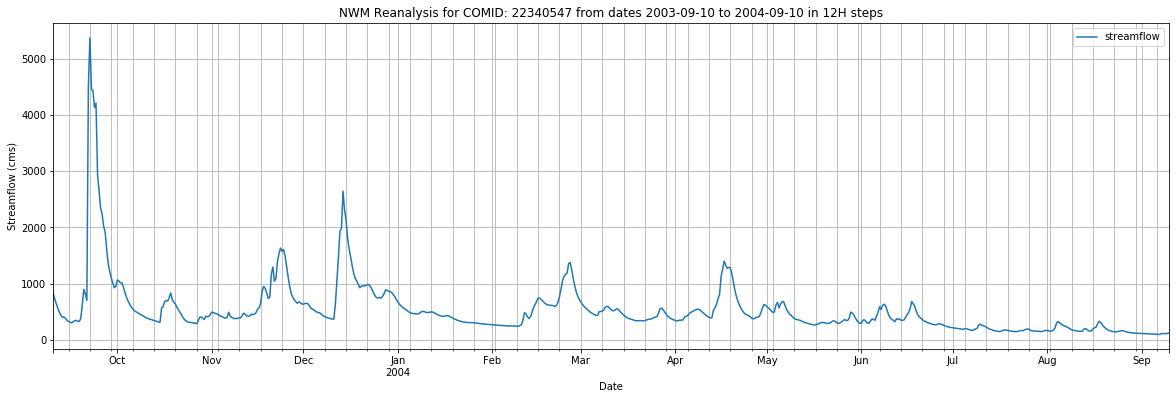

In [33]:
plotReanalysis(df, comid, freq)

In [31]:
print(round((time()-start), 2), 'seconds to access', sum([os.path.getsize(f) for f in files])/1e9, 'GB of data and produce a time series plot')

152.13 seconds to access 13.149859792 GB of data and produce a time series plot
